<div style="background-color:white">
  <div align="center">
    <img src="../../imgs/techfak_logo.jpg" width="400" height="250">
    <hr>
    <h1 style="color:black">Identify Trial Population for Clinical Studies on Diabetes<h1>
    <img src="https://www.mad.tf.fau.de/files/2019/04/logo_mad.png" width="230" height="150">
        <h2>Data Analysis Notebook (Clincal EDA)</h2>
  </div>
  <hr>
</div>

### `Outline of the Notebook`

- [1. Import Packages](#1)
- [2. Load the Dataset](#2)
- [3. Data Wrangling](#3)
- [4. Exploratory Data Analysis](#4)

### `The Dataset Features`

1. encounter_id: Unique identifier of an encounter (numeric)
2. patient_nbr: Unique identifier of a patient (numeric)
3. race: (categorical)
    - Value 1: Caucasian
    - Value 2: Asian
    - Value 3: African American
    - Value 4: Hispanic
    - Value 5: other
4. gender: (1= male, 0 = female, 2 = unknown) (categorical)
5. age: Grouped in 5-year intervals (numerical in buckets)
6. weight: Weight in pounds (numerical)
7. admission_type_id: 9 distinct admission types (categorical)
8. discharge_disposition_id: 29 distinct dispositions (categorical)
9. admission_source_id: 21 distict sources (categorical)
10. time_in_hospital: Integer number of days between admission and discharge (numerical)
11. payer_code: 23 distinct codes (categorical)
12. medical_specialty: 84 distinct values (categorical)
13. primary_diagnosis_code: primary ICD9 - CM code set (categorical)
14. other_diagnosis_codes: secondary diagnosis code (categorical array)
15. number_outpatient: number of outpatient visits (numerical)
16. number_inpatient: number of inpatient visits (numerical)
17. number_emergency: number of emergency visits (numerical)
18. num_lab_procedures: Number of lab tests performed during the encounter (numerical)
19. number_diagnoses: Number of diagnoses entered to the system (numerical)
20. num_medications: Number of distinct generic names administered (numerical)
21. num_procedures: umber of procedures (other than lab tests) (numerical)
22. ndc_code: NDC codes for drug prescription (categorical)
23. max_glu_serum: Indicates the range of the result  (categorical)
24. A1Cresult: Indicates the range of the result  (categorical)
25. change: Indicates if there was a change in diabetic medication (categorical)

<a name='1'></a>
## 1. Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain

import tensorflow as tf
import tensorflow_data_validation as tfdv

import os
import sys  
sys.path.insert(0, '../Scripts')

from utils import check_null_values, count_unique_values

os.environ['KMP_DUPLICATE_LIB_OK']='True'

<a name='2'></a>
## 2. Load the Dataset

['primary_diagnosis_code', 'other_diagnosis_codes', 'ndc_code']

In [2]:
dataset_path = "../../data/diabetic_data.csv"
ids_mapping_path = "../../data/schemas/IDs_mapping.csv"
ndc_lookup_path = "../../data/schemas/ndc_lookup_table.csv"
schema_path = "../../data/schemas/project_data_schema.csv"

In [3]:
data = pd.read_csv(dataset_path)
ndc_lookup = pd.read_csv(ndc_lookup_path)
ids_mapping = pd.read_csv(ids_mapping_path)
schema = pd.read_csv(schema_path)

In [4]:
schema.loc[7]['Description']

'Integer identifier corresponding to 29 distinct values, for example, discharged to home, expired, and not available'

In [5]:
ids_mapping

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available
...,...,...
62,22,Transfer from hospital inpt/same fac reslt in...
63,23,Born inside this hospital
64,24,Born outside this hospital
65,25,Transfer from Ambulatory Surgery Center


In [6]:
medications = ['acarbose', 'acetohexamide', 'chlorpropamide', 'citoglipton', 'glimepiride',
              'glimepiride-pioglitazone', 'glipizide', 'glipizide-metformin', 'glyburide',
              'glyburide-metformin', 'insulin', 'metformin', 'metformin-pioglitazone',
              'metformin-rosiglitazone', 'miglitol', 'nateglinide', 'pioglitazone',
              'repaglinide', 'rosiglitazone', 'tolazamide', 'tolbutamide', 'troglitazone']

In [7]:
medication_df = data[medications]

In [8]:
processed_df = data.drop(medications, axis=1)

In [9]:
processed_df.rename(columns={"diag_1": "primary_diagnosis_code"}, inplace=True)
processed_df['secondary_diagnosis_codes'] = processed_df['diag_2'] + "|" + processed_df['diag_3']
processed_df = processed_df.drop(['diag_2', 'diag_3', 'examide', 'diabetesMed'], axis=1)

In [10]:
processed_df.shape

(101766, 25)

### Encounter Level

In [11]:
print(f"Length of dataset: {processed_df.shape[0]} Features of dataset: {processed_df.shape[1]}")
print(f"Unique patient encounters: {data['encounter_id'].nunique()}")
print(f"Unique patients: {data['patient_nbr'].nunique()}")

Length of dataset: 101766 Features of dataset: 25
Unique patient encounters: 101766
Unique patients: 71518


In [12]:
full_data_stats = tfdv.generate_statistics_from_dataframe(processed_df) 
tfdv.visualize_statistics(full_data_stats)

<a name='3'></a>
## 3. Data Exploration

In [13]:
numerical_features = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
                     'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

categorical_features = ['race', 'gender', 'medical_specialty', 'primary_diagnosis_code', 
                        'secondary_diagnosis_codes', 'change', 'readmitted', 'A1Cresult', 'change']

In [14]:
len(numerical_features)

8

In [15]:
len(categorical_features)

9

### 3.2 Missing Values

In [16]:
check_null_values(data[numerical_features + ['weight']])

,columns,percent_null,percent_zero,?
time_in_hospital,time_in_hospital,0.0,0.000000,0.000000
num_lab_procedures,num_lab_procedures,0.0,0.000000,0.000000
num_procedures,num_procedures,0.0,45.842423,0.000000
num_medications,num_medications,0.0,0.000000,0.000000
number_outpatient,number_outpatient,0.0,83.551481,0.000000
number_emergency,number_emergency,0.0,88.814535,0.000000
number_inpatient,number_inpatient,0.0,66.456380,0.000000
number_diagnoses,number_diagnoses,0.0,0.000000,0.000000
weight,weight,0.0,0.000000,0.968585


**weight** has 96.85% values which are marked as "?", so I dropped it because it is useless then

In [17]:
processed_df = processed_df.drop(['weight'], axis=1)

print(f"Final features after selection: {processed_df.shape[1]}")

Final features after selection: 24


<a name='4'></a>
## 4. Exploratory Data Analysis

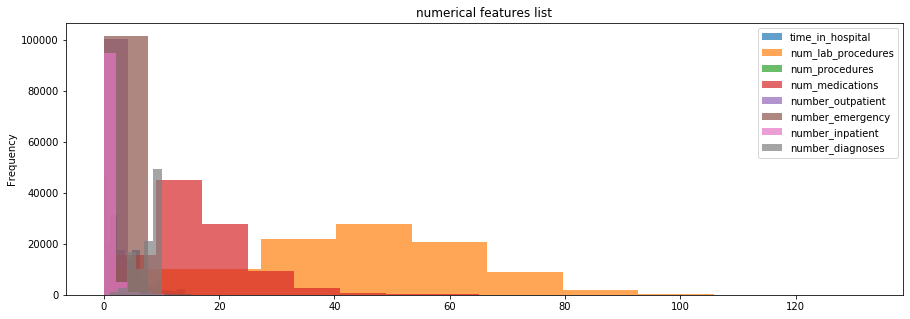

In [18]:
plt.figure(figsize=(15,5))
for numerical_feature in numerical_features:
    processed_df[numerical_feature].plot(kind="hist", title="numerical features list", alpha=0.7)
    plt.legend()
plt.show()

## Gaussian Distribution

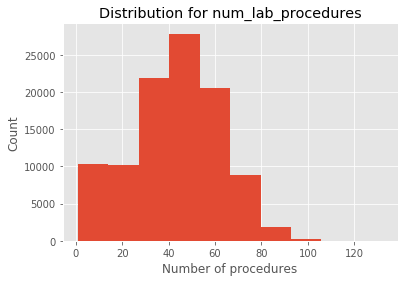

In [19]:
plt.style.use('ggplot')
plt.hist(processed_df['num_lab_procedures'])
plt.xlabel('Number of procedures')
plt.ylabel('Count')
plt.title('Distribution for num_lab_procedures')
plt.show()

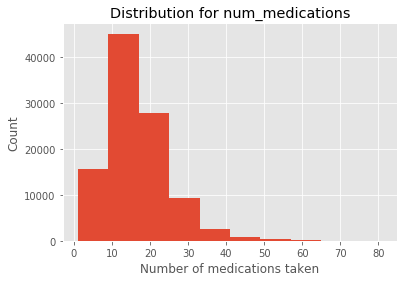

In [20]:
# This looks like a right-skewed gaussian distribution
plt.style.use('ggplot')
plt.hist(processed_df['num_medications'])
plt.xlabel('Number of medications taken')
plt.ylabel('Count')
plt.title('Distribution for num_medications')
plt.show()

## Kardinality

- The original kardinality of Primary Codes are 717
- The original kardinality of Other Codes are 849

Because of the | Piple symbal it is actually less than what count_unique_values says

We can still see that:

- medical_specialty

has a high kardinality

In [21]:
count_unique_values(processed_df, categorical_features)

,columns,cardinality
race,race,6
gender,gender,3
medical_specialty,medical_specialty,73
primary_diagnosis_code,primary_diagnosis_code,717
secondary_diagnosis_codes,secondary_diagnosis_codes,19374
change,change,2
readmitted,readmitted,3
A1Cresult,A1Cresult,4
change,change,2


In [22]:
all_primary_codes = np.unique(list(chain(*processed_df['primary_diagnosis_code'].map(lambda x: x.split('|')).tolist())))
all_other_codes = np.unique(list(chain(*processed_df['secondary_diagnosis_codes'].map(lambda x: x.split('|')).tolist())))

print(f"Unique Primary Codes: {len(all_primary_codes)}")
print(f"Unique Other Codes: {len(all_other_codes)}")

Unique Primary Codes: 717
Unique Other Codes: 849


## Demographic Overview

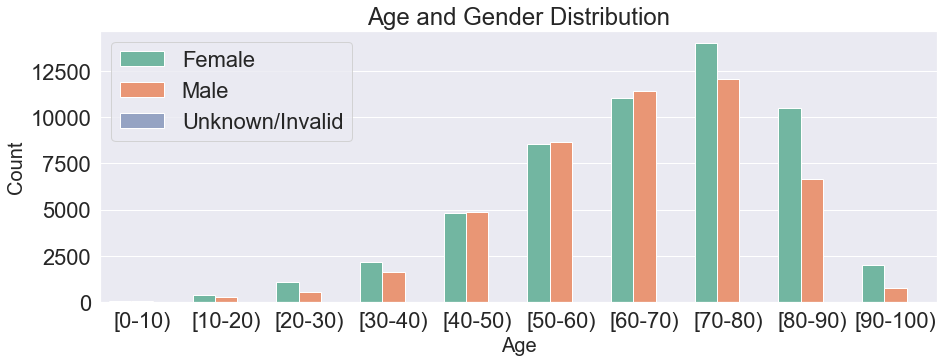

In [59]:
plt.figure(figsize=(15,5))
plt.title("Age and Gender Distribution")
ax = sns.countplot(x="age", data=processed_df, hue="gender", palette="Set2")
ax.set_xlabel("Age",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.legend(loc="upper left")
plt.show()

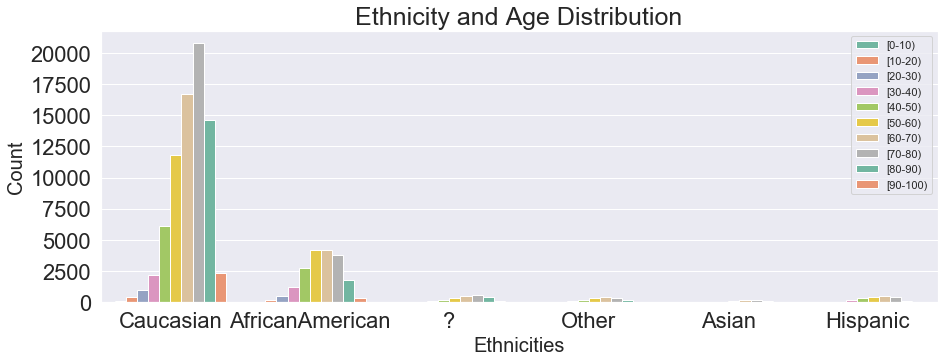

In [56]:
plt.figure(figsize=(15,5))
plt.title("Ethnicity and Age Distribution", fontsize=25)
sns.set(font_scale = 1)
ax = sns.countplot(x="ethnicity", 
                   data=processed_df.rename(columns={'race': 'ethnicity'}), 
                   hue="age", 
                   palette="Set2")

ax.set_xlabel("Ethnicities",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.legend(loc="upper right")
plt.show()

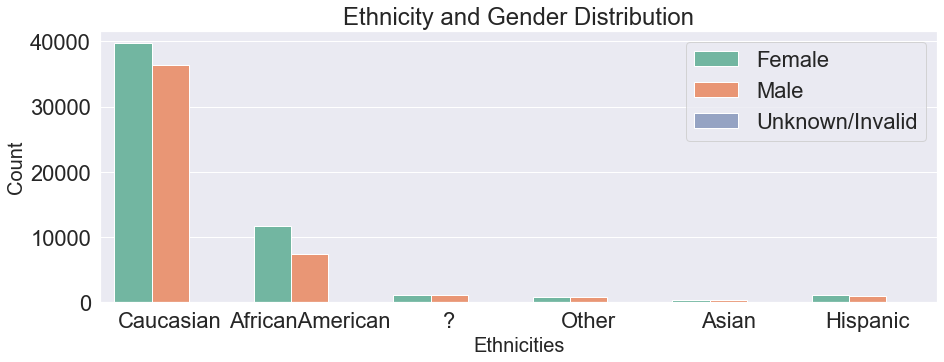

In [57]:
plt.figure(figsize=(15,5))
sns.set(font_scale = 2)
plt.title("Ethnicity and Gender Distribution")
ax = sns.countplot(x="ethnicity", data=processed_df.rename(columns={'race': 'ethnicity'}), hue="gender", palette="Set2")
ax.set_xlabel("Ethnicities",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.legend(loc="upper right")
plt.show()

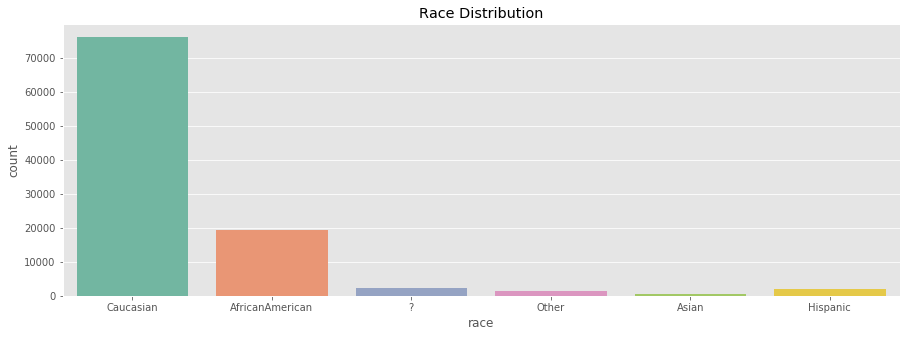

In [26]:
plt.figure(figsize=(15,5))
plt.title("Race Distribution")
ax = sns.countplot(x="race", data=processed_df, palette="Set2")

## Reduce Dimensionality of the NDC Code Feature

There are many codes that map to the same or similar drug. We are provided with many different drugs who could be produces by many different companies with different ndc codes. I use the official (https://ndclist.com/) to map the drug names to a common generic drug name to reduce the dimensionality of different drugs. I created therefore a new column called "drug_name" for the generic drug that was used for the patient. If the patient was precribed with multiple drugs, I encapsulated it and created a new row for the other drug. This therefore produces a line level instead of the encounter level.

In [27]:
set(np.array(medication_df).flatten())

{'Down', 'No', 'Steady', 'Up'}

### medication mapping

In [28]:
processed_med_names = {}

for med in medications:
    processed_med_names[med] = " ".join([m.capitalize() for m in med.split("-")])
    
one_hot_medications = medication_df.replace({"No": 0, "Down": 1, "Steady": 1, "Up": 1})

one_hot_medications['meds']= ''

for col_name in one_hot_medications.columns:
    one_hot_medications.loc[one_hot_medications[col_name]==1,'meds'] = one_hot_medications['meds']+' '+col_name

In [ ]:
processed_df['drug_name'] = one_hot_medications['meds']
line_level_df = pd.DataFrame(columns=processed_df.columns)

In [ ]:
line_level_df.info()

### create mappings

### make encounter to line level

In [ ]:
for row in processed_df.iterrows():
    meds = row[1]["drug_name"].strip().split(" ")
    
    if len(meds[0]) == 0:
        row[1]['drug_name'] = np.nan
        line_level_df = line_level_df.append(row[1])
    
    elif len(meds) > 1:  
        for med in meds:
            row[1]['drug_name'] = med
            line_level_df = line_level_df.append(row[1])
    elif len(meds) == 1:
        row[1]['drug_name'] = med
        line_level_df = line_level_df.append(row[1])

In [ ]:
line_level_df = line_level_df.drop_duplicates()

In [ ]:
line_level_df['drug_name'] = line_level_df[~line_level_df['drug_name'].isna()]['drug_name'].apply(lambda x: processed_med_names[x])

In [ ]:
# Number of unique values should be less for the new output field
assert processed_df['drug_name'].nunique() > line_level_df['drug_name'].nunique()

In [ ]:
line_level_df.to_csv("../../data/final_preprocessed_df.csv", index=False)